## IMPORT LIBRARIES

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras_preprocessing.text import Tokenizer
import keras
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Dense
from keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
import datetime
from keras.callbacks import TensorBoard

## IMPORT DATASET

In [101]:
dataset = pd.read_csv('sentiment_tweets3.csv')
dataset

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...,...
10309,802309,No Depression by G Herbo is my mood from now o...,1
10310,802310,What do you do when depression succumbs the br...,1
10311,802311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,802312,dont mistake a bad day with depression! everyo...,1


## PREPARING THE DATASET

In [102]:
dataset.columns ## checking through the dataset to decide the needed one for the analysis

Index(['Index', 'message to examine', 'label (depression result)'], dtype='object')

In [103]:
## re naming the columns
dataset= dataset.rename(columns = {'message to examine': 'message', 'label (depression result)': 'label'})

In [104]:
## dataset after renaming
dataset

,Index,message,label
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...,...
10309,802309,No Depression by G Herbo is my mood from now o...,1
10310,802310,What do you do when depression succumbs the br...,1
10311,802311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,802312,dont mistake a bad day with depression! everyo...,1


In [105]:
## the message and label will be used for the analysis
dataset = dataset[['message', 'label']]

In [106]:
dataset.head(10)

,message,label
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
5,so sleepy. good times tonight though,0
6,"@SilkCharm re: #nbn as someone already said, d...",0
7,23 or 24ï¿½C possible today. Nice,0
8,nite twitterville workout in the am -ciao,0
9,"@daNanner Night, darlin'! Sweet dreams to you",0


In [107]:
dataset['label'].value_counts() ## counts of positive and negative

0    8000
1    2314
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='Count'>

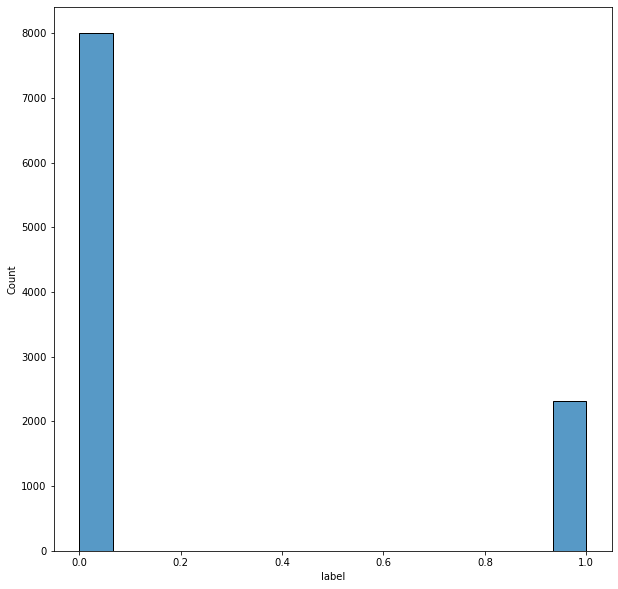

In [108]:
## histogram distribution for the label counts
fig = plt.figure(figsize = (10,10))
sns.histplot(data = dataset, x = 'label')

## TOKENIZING THE TEXT TO NUMERICAL VALUES

In [109]:
tokenizer = Tokenizer(num_words = 6000, split = ' ')
tokenizer.fit_on_texts(dataset['message'].values)
vocab_size = len(tokenizer.word_index) + 1
X = tokenizer.texts_to_sequences(dataset['message'].values)
X = pad_sequences(X)
y = dataset['label'].values

In [110]:
X

array([[   0,    0,    0, ...,  209,   20,   94],
       [   0,    0,    0, ...,  578,   19,  267],
       [   0,    0,    0, ...,   19,  206,  537],
       ...,
       [   0,    0,    0, ...,   46, 3503,   11],
       [   0,    0,    0, ...,  140,   81, 2507],
       [   0,    0,    0, ...,    0,    0,  658]])

In [111]:
#y = y.reshape(-1, 1) ## reshaping

In [112]:
y 

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

## SPLITTING DATA

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
print(X_train.shape, y_train.shape) ## printing the shape of the train set
print(X_test.shape, y_test.shape) ## printing the shape of the test set

(8251, 72) (8251,)
(2063, 72) (2063,)


## DEFINING THE MODEL

In [114]:
embedded_dim = 70
model = tf.keras.models.Sequential()
model.add(Embedding(vocab_size , embedded_dim, input_length = X.shape[1])) ## lowering the dimensionality of categorical variables
model.add(SpatialDropout1D(0.25)) ## 
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2)) ## regularizing to creates a robust network
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']) ## multi class classification
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 72, 70)            1623720   
                                                                 
 spatial_dropout1d_10 (Spati  (None, 72, 70)           0         
 alDropout1D)                                                    
                                                                 
 lstm_10 (LSTM)              (None, 50)                24200     
                                                                 
 dropout_10 (Dropout)        (None, 50)                0         
                                                                 
 dense_10 (Dense)            (None, 2)                 102       
                                                                 
Total params: 1,648,022
Trainable params: 1,648,022
Non-trainable params: 0
___________________________________________

In [115]:
## training on 50 epochs
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_test, y_test))

Epoch 1/50
258/258 [==============================] - 29s 102ms/step - loss: 0.2121 - accuracy: 0.9107 - val_loss: 0.0182 - val_accuracy: 0.9966
Epoch 2/50
258/258 [==============================] - 25s 98ms/step - loss: 0.0172 - accuracy: 0.9968 - val_loss: 0.0155 - val_accuracy: 0.9961
Epoch 3/50
258/258 [==============================] - 27s 106ms/step - loss: 0.0087 - accuracy: 0.9984 - val_loss: 0.0192 - val_accuracy: 0.9942
Epoch 4/50
258/258 [==============================] - 27s 106ms/step - loss: 0.0059 - accuracy: 0.9990 - val_loss: 0.0181 - val_accuracy: 0.9956
Epoch 5/50
258/258 [==============================] - 30s 114ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.0215 - val_accuracy: 0.9952
Epoch 6/50
258/258 [==============================] - 30s 116ms/step - loss: 0.0052 - accuracy: 0.9988 - val_loss: 0.0214 - val_accuracy: 0.9961
Epoch 7/50
258/258 [==============================] - 32s 124ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.0229 - val_acc

## VISUALIZING THE ACCURACY AND LOSS

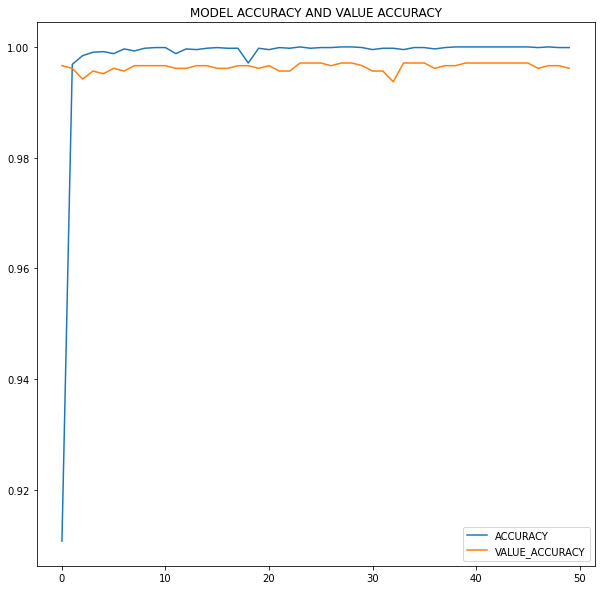

In [116]:
## plotting a histogram over the 50 epochs and plotting the accuracy and value accuracy
plt.figure(figsize = (10,10))
plt.plot(history.history['accuracy'], label = 'ACCURACY')
plt.plot(history.history['val_accuracy'], label = 'VALUE_ACCURACY')
plt.title('MODEL ACCURACY AND VALUE ACCURACY')
plt.legend()
plt.show()

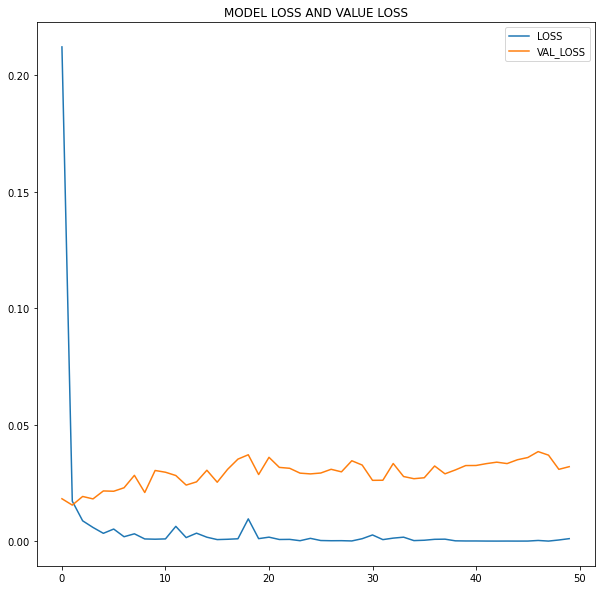

In [117]:
plt.figure(figsize = (10,10))
plt.plot(history.history['loss'], label = 'LOSS')
plt.plot(history.history['val_loss'], label = 'VAL_LOSS')
plt.title('MODEL LOSS AND VALUE LOSS')
plt.legend()
plt.show()

## MEAN SQUARE ROOT

In [118]:
test_error_rate = model.evaluate(X_test, y_test, verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(test_error_rate))

The mean squared error (MSE) for the test data set is: [0.03195676580071449, 0.9961221814155579]
